## Preprocess data

First read data from directory. After reading data, convert the categorical column into numerical values that can be put into neural network.

Using 'glob' package we can read data files containing specific characters. 

In [1]:
import pandas as pd

In [2]:
path = "D:/rfiles/feature_matrix/feature_matrix_time_1024_ball.csv"
df = pd.read_csv(path)
df.head()

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault_type
0,0.21779,-0.19860,0.012421,0.074997,0.075982,-0.162737,-0.249050,2.866329,6.117247,Normal
1,0.21216,-0.27287,0.011589,0.069499,0.070425,-0.107232,0.178607,3.012546,6.076971,Normal
2,0.21237,-0.20820,0.014643,0.077034,0.078377,0.050254,-0.381294,2.709611,5.352335,Normal
3,0.22301,-0.22676,0.010937,0.078972,0.079688,-0.163349,-0.040365,2.798539,7.286094,Normal
4,0.18859,-0.18692,0.013359,0.074959,0.076104,-0.028402,-0.326834,2.478067,5.696816,Normal


Now we will read the first files and use it in further analysis. 

In [3]:
df["fault_type"].value_counts()

Normal        1657
0.021 inch     475
0.014 inch     475
0.007 inch     473
0.028 inch     471
Name: fault_type, dtype: int64

Now we will split the total data into training and test set. The dataset is unbalanced (it has more normal data as compared to other faulty data types). So first we create a balanced dataset and then form a training and test set.

In [4]:
import numpy as np
from numpy.random import choice 
np.random.seed(1)
index = np.array([choice(np.arange(0,1657),450,replace = False),
                choice(np.arange(1657,2130),450,replace = False),
                choice(np.arange(2130,2605),450,replace = False),
                choice(np.arange(2605,3080),450,replace = False),
                choice(np.arange(3080,3551),450,replace = False)])
index = index.ravel()
data = df.iloc[index,]
data = data.reset_index(drop = True)
test_index = np.array([choice(np.arange(0,450),150, replace = False),
                     choice(np.arange(450,2*450),150, replace = False),
                     choice(np.arange(2*450,3*450),150, replace = False),
                     choice(np.arange(3*450,4*450),150, replace = False),
                     choice(np.arange(4*450,5*450),150, replace = False)])
test_index = test_index.ravel()
test_data = data.iloc[test_index,]
train_data = data.drop(data.index[test_index])

# Shuffle data
train_data = train_data.sample(frac = 1, random_state = 2)
test_data = test_data.sample(frac = 1, random_state = 3)

# Convert categorical lables to numberic entries

category_labels = ['Normal', '0.007 inch', '0.014 inch','0.021 inch', '0.028 inch']
# test_labels = test_data['fault_type']
test_labels = pd.Categorical(test_data['fault_type'],categories= category_labels).codes # Produces ndarrays
# train_labels = train_data['fault_type']
train_labels = pd.Categorical(train_data['fault_type'], categories = category_labels).codes

In [5]:
print(data.shape,test_data.shape,train_data.shape,test_labels.shape,train_labels.shape)

(2250, 10) (750, 10) (1500, 10) (750,) (1500,)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn
from sklearn import preprocessing

In [7]:
# Convert labels to categorical data
train_data = train_data.iloc[:,0:9]
test_data = test_data.iloc[:,0:9]
# Scale the data
train_data = preprocessing.scale(train_data)
test_data = preprocessing.scale(test_data)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(1500, 9) (750, 9) (1500, 5) (750, 5)


In [73]:
model = Sequential([
    layers.Dense(16,activation = 'relu', input_dim = 9),
#     layers.Dense(5,activation = 'relu'),
#     layers.Dense(5,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(5,activation = 'softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 85        
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [75]:
callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)]

In [76]:
history = model.fit(train_data,train_labels,epochs = 100, validation_split = 0.2, verbose = 2,callbacks = callbacks)

Train on 1200 samples, validate on 300 samples
Epoch 1/100
1200/1200 - 0s - loss: 1.5123 - accuracy: 0.2225 - val_loss: 1.3124 - val_accuracy: 0.3367
Epoch 2/100
1200/1200 - 0s - loss: 1.2875 - accuracy: 0.4025 - val_loss: 1.1261 - val_accuracy: 0.5667
Epoch 3/100
1200/1200 - 0s - loss: 1.1366 - accuracy: 0.5600 - val_loss: 1.0064 - val_accuracy: 0.6900
Epoch 4/100
1200/1200 - 0s - loss: 1.0509 - accuracy: 0.5992 - val_loss: 0.9246 - val_accuracy: 0.7033
Epoch 5/100
1200/1200 - 0s - loss: 0.9739 - accuracy: 0.6358 - val_loss: 0.8663 - val_accuracy: 0.7067
Epoch 6/100
1200/1200 - 0s - loss: 0.9436 - accuracy: 0.6400 - val_loss: 0.8177 - val_accuracy: 0.7100
Epoch 7/100
1200/1200 - 0s - loss: 0.9064 - accuracy: 0.6492 - val_loss: 0.7791 - val_accuracy: 0.7200
Epoch 8/100
1200/1200 - 0s - loss: 0.8505 - accuracy: 0.6717 - val_loss: 0.7461 - val_accuracy: 0.7167
Epoch 9/100
1200/1200 - 0s - loss: 0.8247 - accuracy: 0.6717 - val_loss: 0.7167 - val_accuracy: 0.7300
Epoch 10/100
1200/1200 - 0

Epoch 80/100
1200/1200 - 0s - loss: 0.4623 - accuracy: 0.8100 - val_loss: 0.3915 - val_accuracy: 0.8100
Epoch 81/100
1200/1200 - 0s - loss: 0.4806 - accuracy: 0.7975 - val_loss: 0.3904 - val_accuracy: 0.8233
Epoch 82/100
1200/1200 - 0s - loss: 0.4754 - accuracy: 0.8025 - val_loss: 0.3914 - val_accuracy: 0.8200
Epoch 83/100
1200/1200 - 0s - loss: 0.4801 - accuracy: 0.8008 - val_loss: 0.3893 - val_accuracy: 0.8100
Epoch 84/100
1200/1200 - 0s - loss: 0.4642 - accuracy: 0.8117 - val_loss: 0.3872 - val_accuracy: 0.8167
Epoch 85/100
1200/1200 - 0s - loss: 0.4647 - accuracy: 0.8025 - val_loss: 0.3885 - val_accuracy: 0.8200
Epoch 86/100
1200/1200 - 0s - loss: 0.4604 - accuracy: 0.8008 - val_loss: 0.3842 - val_accuracy: 0.8267
Epoch 87/100
1200/1200 - 0s - loss: 0.4630 - accuracy: 0.8042 - val_loss: 0.3851 - val_accuracy: 0.8133
Epoch 88/100
1200/1200 - 0s - loss: 0.4736 - accuracy: 0.8083 - val_loss: 0.3835 - val_accuracy: 0.8267
Epoch 89/100
1200/1200 - 0s - loss: 0.4668 - accuracy: 0.8042 - 

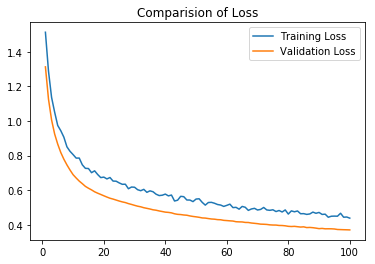

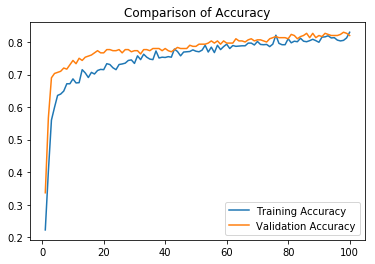

In [77]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = np.arange(1,len(train_loss)+1)
plt.figure()
plt.plot(epochs, train_loss, label = "Training Loss")
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.legend()
plt.title("Comparision of Loss")
plt.show()
plt.figure()
plt.plot(epochs, train_acc, label = "Training Accuracy")
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Comparison of Accuracy")
plt.legend()
plt.show()

In [78]:
test_loss,test_acc = model.evaluate(test_data, test_labels)

750/750 [==============================] - 0s 35us/sample - loss: 0.3815 - accuracy: 0.8520


In [79]:
print(test_acc)

0.852


In [80]:
prediction = model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))
    

In [81]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

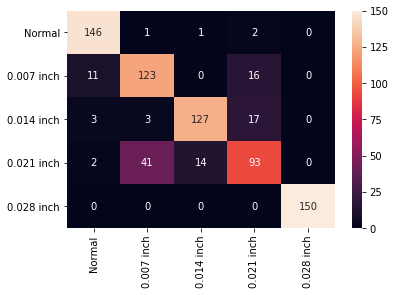

In [82]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels)
plt.xticks(rotation = 90)